In [164]:
!pip install python-louvain
from bs4 import BeautifulSoup
from collections import Counter
import community as community_louvain
import datetime
from fa2 import ForceAtlas2
import json
import matplotlib.pyplot as plt
import networkx as nx
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords as sw
from nltk.corpus import words
from nltk.probability import FreqDist
#from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import WhitespaceTokenizer
import numpy as np
import pandas as pd
import pickle
from PIL import Image
import re
import wptools
import wordcloud
from wordcloud import ImageColorGenerator, WordCloud


ZODIAC_SIGNS = ['Aquarius', 'Aries', 'Cancer', 'Capricorn', 'Gemini', 'Leo', 'Libra', 'Pisces', 'Sagittarius', 'Scorpio', 'Taurus', 'Virgo']
ZODIAC_ELEMENTS = ['Water', 'Fire', 'Earth', 'Air']

color_legend_zodiac = {
    'Aries': '#FFFF66', 'Taurus': 'gold', 'Gemini': 'orange', 'Cancer': 'orangered', 'Leo': 'crimson', 'Virgo': 'mediumvioletred', 'Libra': 'darkviolet', 'Scorpio': 'mediumblue', 'Sagittarius': 'royalblue', 'Capricorn': 'c', 'Aquarius': 'green', 'Pisces': 'limegreen'}

color_legend_element = {'Air': 'yellow', 'Fire': 'orange', 'Water': 'blue', 'Earth': 'green'}


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lulka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lulka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\lulka\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [4]:
# Load the dataframe with all of our data
df = pd.read_pickle('./datafiles/full_df.pickle')

# Remove NaN and duplicates
df.drop_duplicates(subset ="Handle", inplace = True)
df.dropna(inplace = True)
df.reset_index(drop=True, inplace=True)

df.head()

Name           WikiLink         Handle    Birthday ZodiacSign  \
0       Barack Obama       Barack Obama   @barackobama  1961-08-04        Leo   
1      Justin Bieber      Justin Bieber  @justinbieber  1994-03-01     Pisces   
2         KATY PERRY         Katy Perry     @katyperry  1984-10-25    Scorpio   
3            Rihanna            Rihanna       @rihanna  1988-02-20     Pisces   
4  Cristiano Ronaldo  Cristiano Ronaldo     @cristiano  1985-02-05   Aquarius   

  Element                                             Tweets  \
0    Fire  ['More than anyone else, I wrote my book for y...   
1   Water  ['Happy 5 years of Purpose', 'Rockin Around th...   
2   Water  ['❗️KATYCATS N KATYCLOWNTS❗️I’ve been cookin’ ...   
3   Water  ['The faces of history makers, boundary breake...   
4     Air  ['@DjokerNole not bad bro🤔😅', 'P𝐫𝐞𝐩𝐚𝐫𝐚𝐝𝐨𝐬! 🇵🇹💪...   

                                           Following         Id  
0  [1330457336, 3383203552, 30354991, 3157910605,...     813286  
1  [1096286154930843648, 30973513, 3320745074, 23...   27260086  
2  [939091, 180535644, 4185877812, 3564127636, 62...   21447363  
3  [1116089461480153088, 480769467, 401802609, 11...   79293791  
4  [1324677118660280320, 4793420675, 108557129919...  155659213

In [5]:
# Create the nodes of the graph
G = nx.DiGraph()
G.add_nodes_from(df.Handle)

# Set the attributes of the nodes
nx.set_node_attributes(G, dict(zip(df.Handle, df.ZodiacSign)), "zodiac")
nx.set_node_attributes(G, dict(zip(df.Handle, df.Element)), "element")
nx.set_node_attributes(G, dict(zip(df.Handle, df.Id)), "id")

# Create the links of the graph
user_names_by_id = {value : key for (key, value) in nx.get_node_attributes(G, 'id').items()}

for user in user_names_by_id.values():
    for following in df.loc[df['Handle'] == user]["Following"]:
        for friend in following:
            try:
                friend_name = user_names_by_id[friend]
                G.add_edge(user, friend_name)
            except:
                pass
            
print("The number of nodes in the network is: ", G.number_of_nodes())
print("The number of links in the network is: ", G.number_of_edges())

The number of nodes in the network is:  2151
The number of links in the network is:  124721


In [6]:
# Remove isolates
isolated = list(nx.isolates(G))
G.remove_nodes_from(isolated)

# Select giant connected component
largest_cc = max(nx.weakly_connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

# Create undirected graph
U = G.to_undirected()

print("The number of nodes in the network is: ", G.number_of_nodes())
print("The number of links in the network is: ", G.number_of_edges())

The number of nodes in the network is:  2037
The number of links in the network is:  124721


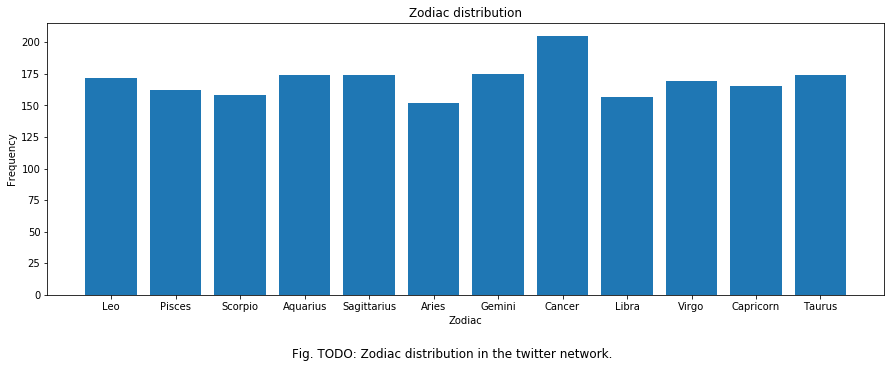

In [292]:
# Plot zodiac distribution

zodiacs = [value for key, value in nx.get_node_attributes(G, 'zodiac').items()]
counts_zodiac = Counter(zodiacs)

# Create histrogram with a bin for each zodiac sign
plt.figure(figsize = (15,5))
plt.bar(range(len(counts_zodiac)), list(counts_zodiac.values()), align='center')
plt.xticks(range(len(counts_zodiac)), list(counts_zodiac.keys()))

# Format plot
plt.title("Zodiac distribution")
plt.ylabel("Frequency")
plt.xlabel("Zodiac")
plt.figtext(
    0.5, 
    -0.05, 
    'Fig. TODO: Zodiac distribution in the twitter network.', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)
plt.show()

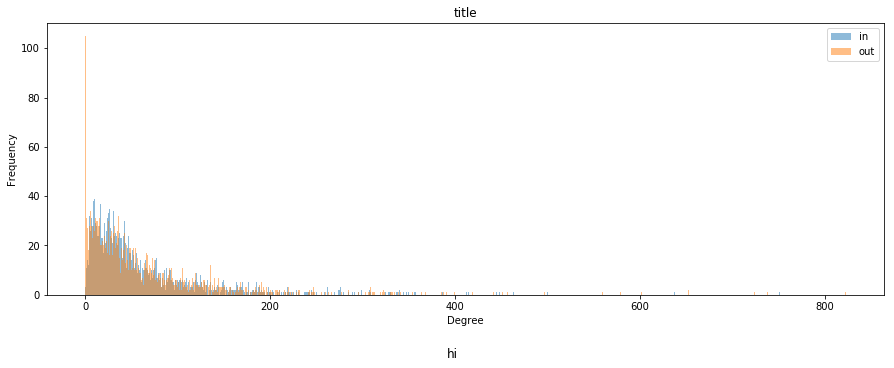

In [255]:
# Plot the in and out degree distribution
plt.figure(figsize = (15,5))

in_degree = [value for key, value in list(G.in_degree())]
plt.hist(in_degree, bins=range(np.min(in_degree), np.max(in_degree)+1), alpha=0.5, label="in")

out_degree = [value for key, value in list(G.out_degree())]
plt.hist(out_degree, bins=range(np.min(out_degree), np.max(out_degree)+1), alpha=0.5, label="out")

plt.title("title")
plt.ylabel("Frequency")
plt.xlabel("Degree")
plt.legend()
plt.figtext(
    0.5, 
    -0.05, 
    'hi', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)
plt.show()

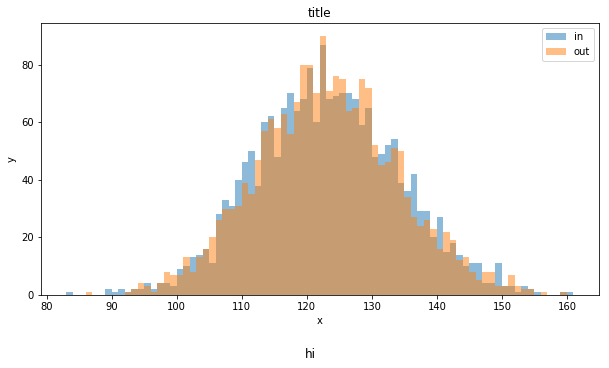

In [80]:
# Check if our network resembles a random network 

k = np.mean([value for key, value in list(G.degree())])
N = G.number_of_nodes()
p = k/(N-1)

ER = nx.erdos_renyi_graph(N, p, directed = True)

plt.figure(figsize = (10,5))

in_degree = [value for key, value in list(ER.in_degree())]
plt.hist(in_degree, bins=range(np.min(in_degree), np.max(in_degree)+1), alpha=0.5, label="in")

out_degree = [value for key, value in list(ER.out_degree())]
plt.hist(out_degree, bins=range(np.min(out_degree), np.max(out_degree)+1), alpha=0.5, label="out")

plt.title("title")
plt.ylabel("y")
plt.xlabel("x")
plt.legend()
plt.figtext(
    0.5, 
    -0.05, 
    'hi', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)
plt.show()

In [268]:
# Edge analysis

# TODO explain why some users follow 0, change to normalized values instead of %

zodiac = nx.get_node_attributes(G, 'zodiac')

out_degree_type = {}
out_degree_percentage = {}

# Iterate through nodes of all edges
for node in G.nodes():
    out_degree_type[node] = {}
    out_degree_percentage[node] = {}

    for sign in ZODIAC_SIGNS:
        out_degree_type[node][sign] = 0
    for node1, node2 in G.edges(node):
        out_degree_type[node][zodiac[node2]] +=1
    out_degree_type[node]['Total'] = sum(out_degree_type[node].values())  
    if out_degree_type[node]['Total'] != 0:
        for sign in ZODIAC_SIGNS:
            #out_degree_percentage[node][sign] = out_degree_type[node][sign]/out_degree_type[node]['Total']
            #TODO: RENAME VARIABLE           
            if np.linalg.norm(out_degree_type[node][sign])  == 0:
                norm = out_degree_type[node][sign] 
            else:
                norm =(out_degree_type[node][sign] / np.linalg.norm(out_degree_type[node][sign]))
            out_degree_percentage[node][sign] = norm
                       
nx.set_node_attributes(G, out_degree_type, "out_degree_type")

In [269]:
sign_out_degree = {}
mean_sign_out_degree = {}
std_sign_out_degree = {}

for sign1 in ZODIAC_SIGNS:
        sign_out_degree[sign1] = {}
        mean_sign_out_degree[sign1] = {}
        std_sign_out_degree[sign1] = {}
        for sign2 in ZODIAC_SIGNS:
            sign_out_degree[sign1][sign2] = []
            
for node, val in out_degree_percentage.items():    
    for sign in ZODIAC_SIGNS:        
        try:
            sign_out_degree[zodiac[node]][sign].append(val[sign])
        except:
            pass

for sign1, val in sign_out_degree.items():
    for sign in ZODIAC_SIGNS: 
        mean_sign_out_degree[sign1][sign] = np.mean(val[sign])
        std_sign_out_degree[sign1][sign] = np.std(val[sign])
          

In [270]:
out_degree = {}
mean_out_degree = {}
std_out_degree = {}

for sign in ZODIAC_SIGNS:
    out_degree[sign] = []
    for node in out_degree_percentage:
        if out_degree_type[node]['Total'] != 0:
            out_degree[sign].append(out_degree_percentage[node][sign])
    mean_out_degree[sign] = np.mean(out_degree[sign])
    std_out_degree[sign] = np.std(out_degree[sign])

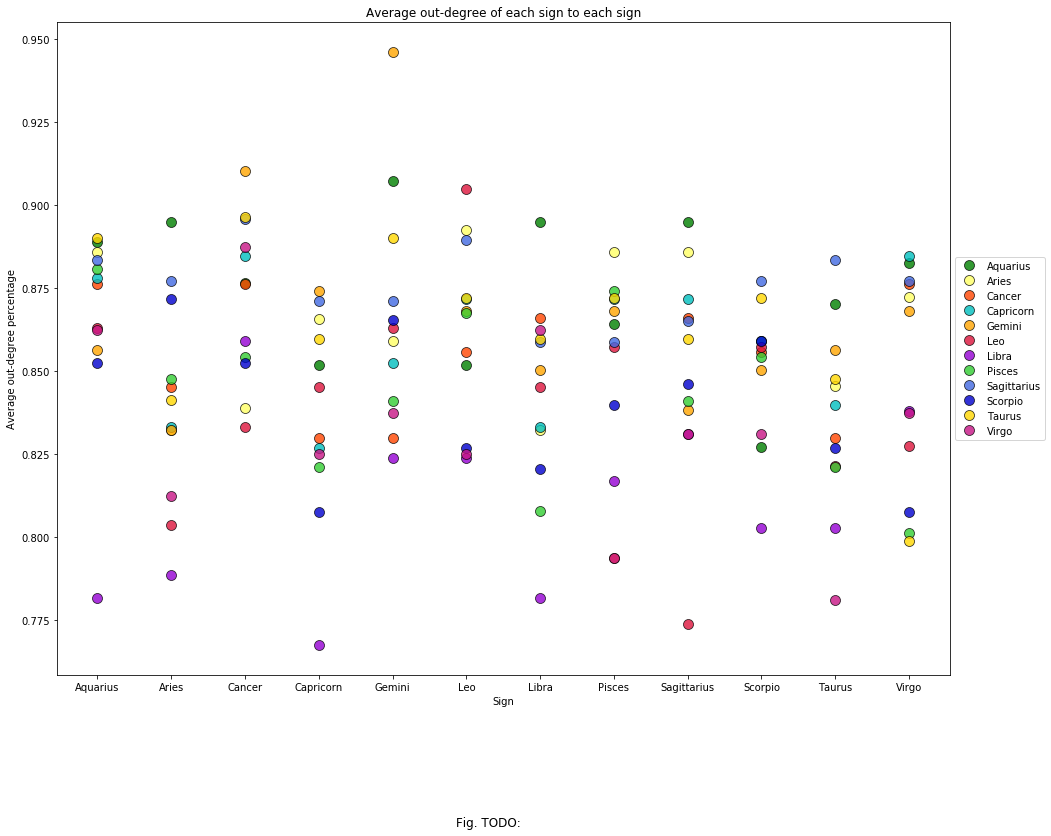

In [271]:
# TODO explain this plot
plt.figure(figsize = (16,12))

# Create legend
ax = plt.subplot(111)
# Put a legend to the right of the current axis
for sign1, mean in mean_sign_out_degree.items():
    #plt.errorbar(list(mean.keys()), list(mean.values()), yerr=std_sign_out_degree[sign1].values(), linewidth=1, fmt='o', capsize=7, ecolor=color_legend_zodiac[sign1], elinewidth=1, markersize=8, color = color_legend_zodiac[sign1], label = sign1, markeredgewidth=0.8, markeredgecolor='k', alpha=0.8)  
    plt.plot(list(mean.keys()), list(mean.values()), 'o', markersize=10, color = color_legend_zodiac[sign1], label = sign1, markeredgewidth=0.8, markeredgecolor='k', alpha=0.8)


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.title("Average out-degree of each sign to each sign")
plt.xlabel("Sign")
plt.ylabel("Average out-degree percentage")            
plt.figtext(
    0.5, 
    -0.05, 
    'Fig. TODO:', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)

plt.show()

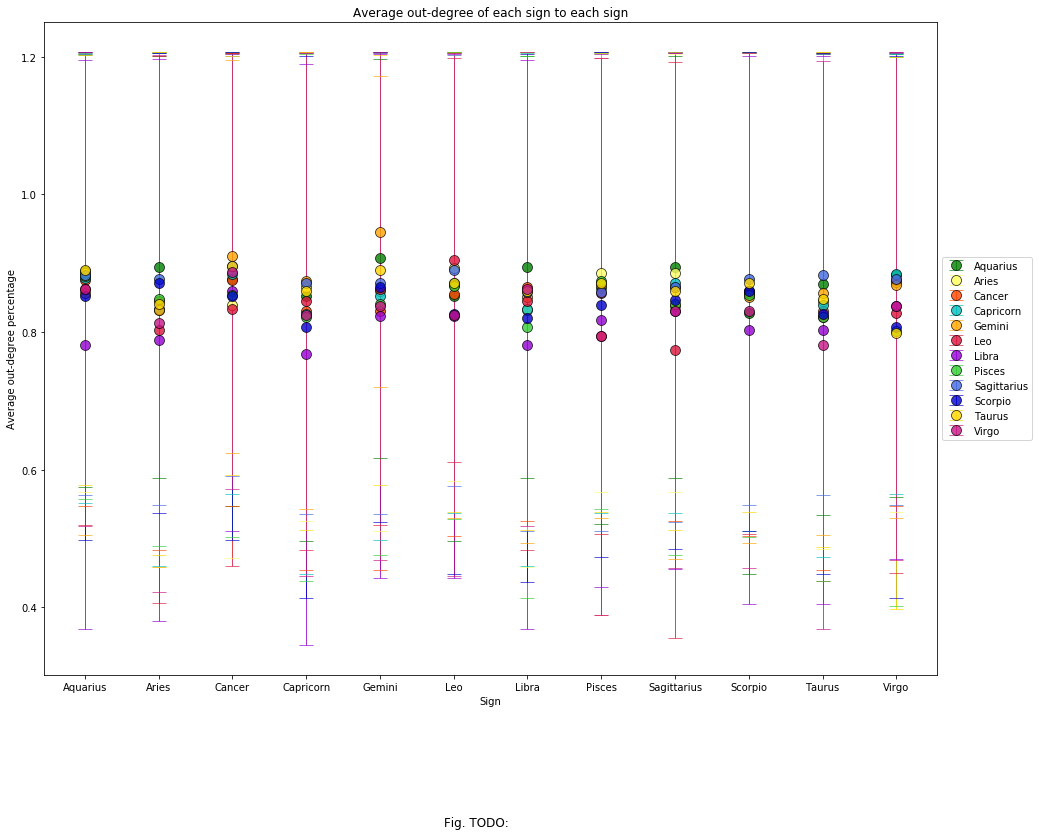

In [272]:
# TODO explain this plot
plt.figure(figsize = (16,12))

# Create legend
ax = plt.subplot(111)
# Put a legend to the right of the current axis
for sign1, mean in mean_sign_out_degree.items():
    plt.errorbar(list(mean.keys()), list(mean.values()), yerr=std_sign_out_degree[sign1].values(), linewidth=1, fmt='o', capsize=7, ecolor=color_legend_zodiac[sign1], elinewidth=1, markersize=10, color = color_legend_zodiac[sign1], label = sign1, markeredgewidth=0.8, markeredgecolor='k', alpha=0.8)  
    #plt.plot(list(mean.keys()), list(mean.values()), 'o', markersize=8, color = color_legend_zodiac[sign1], label = sign1, markeredgewidth=0.8, markeredgecolor='k', alpha=0.8)


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.title("Average out-degree of each sign to each sign")
plt.xlabel("Sign")
plt.ylabel("Average out-degree percentage")            
plt.figtext(
    0.5, 
    -0.05, 
    'Fig. TODO:', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)

plt.show()

In [273]:
element_out_degree = {}
mean_element_out_degree = {}
std_element_out_degree = {}

element_l = nx.get_node_attributes(G, 'element')


for element1 in ZODIAC_ELEMENTS:
        element_out_degree[element1] = {}
        mean_element_out_degree[element1] = {}
        std_element_out_degree[element1] = {}
        for element2 in ZODIAC_ELEMENTS:
            element_out_degree[element1][element2] = []
            
for node, val in out_degree_percentage.items():    
    for sign, sign_val in val.items():
        try:
            element_out_degree[element_l[node]][zodiac_element(sign)].append(sign_val)
        except Exception as e:
            print('fail:', node, sign, e)
            pass

for element1, val in element_out_degree.items():
    for element in ZODIAC_ELEMENTS: 
        mean_element_out_degree[element1][element] = np.mean(val[element])
        std_element_out_degree[element1][element] = np.std(val[element])

In [274]:
def zodiac_element(zodiac_sign):
    earth = ['Capricorn', 'Taurus', 'Virgo' ]
    water = ['Cancer', 'Pisces', 'Scorpio' ]
    fire = ['Leo', 'Aries', 'Sagittarius']
    air = ['Libra', 'Gemini', 'Aquarius']

    if zodiac_sign in earth:
        return 'Earth'
    elif zodiac_sign in water:
        return 'Water'
    elif zodiac_sign in fire:
        return 'Fire'
    elif zodiac_sign in air:
        return 'Air'
    else:
        return ''

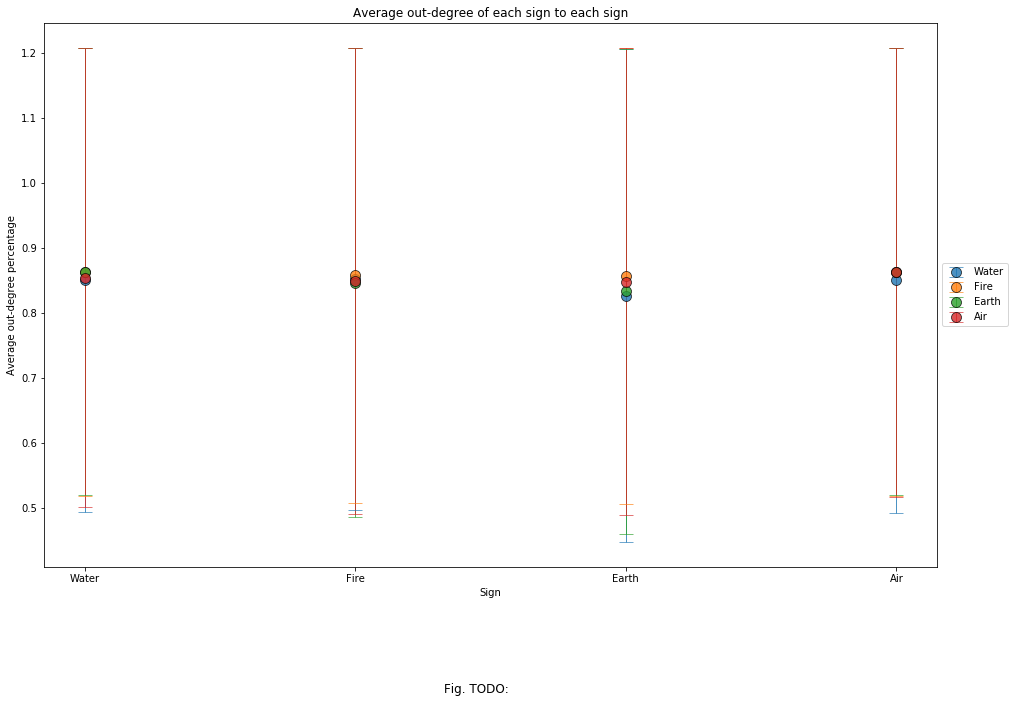

In [275]:
# TODO explain this plot
plt.figure(figsize = (16,10))

# Create legend
ax = plt.subplot(111)
# Put a legend to the right of the current axis
for element, mean in mean_element_out_degree.items():
    plt.errorbar(list(mean.keys()), list(mean.values()), yerr=std_element_out_degree[element].values(), linewidth=1, fmt='o', capsize=7,  elinewidth=1, markersize=10, label = element, markeredgewidth=0.8, markeredgecolor='k', alpha=0.8)  
    #plt.plot(list(mean.keys()), list(mean.values()), 'o', markersize=8, color = color_legend_zodiac[sign1], label = sign1, markeredgewidth=0.8, markeredgecolor='k', alpha=0.8)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title("Average out-degree of each sign to each sign")
plt.xlabel("Sign")
plt.ylabel("Average out-degree percentage")            
plt.figtext(
    0.5, 
    -0.05, 
    'Fig. TODO:', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)

plt.show()

In [ ]:
# TODO check the distribution for each sign/element

[0.8888888888888888, 0.8950617283950617, 0.8765432098765432, 0.8518518518518519, 0.9074074074074074, 0.8518518518518519, 0.8950617283950617, 0.8641975308641975, 0.8950617283950617, 0.8271604938271605, 0.8703703703703703, 0.8827160493827161]
[0.8859060402684564, 0.8322147651006712, 0.8389261744966443, 0.8657718120805369, 0.8590604026845637, 0.8926174496644296, 0.8322147651006712, 0.8859060402684564, 0.8859060402684564, 0.8590604026845637, 0.8456375838926175, 0.87248322147651]
[0.8762886597938144, 0.845360824742268, 0.8762886597938144, 0.8298969072164949, 0.8298969072164949, 0.8556701030927835, 0.865979381443299, 0.7938144329896907, 0.865979381443299, 0.8556701030927835, 0.8298969072164949, 0.8762886597938144]
[0.8782051282051282, 0.8333333333333334, 0.8846153846153846, 0.8269230769230769, 0.8525641025641025, 0.8717948717948718, 0.8333333333333334, 0.8717948717948718, 0.8717948717948718, 0.8589743589743589, 0.8397435897435898, 0.8846153846153846]
[0.8562874251497006, 0.8323353293413174, 

<ErrorbarContainer object of 3 artists>

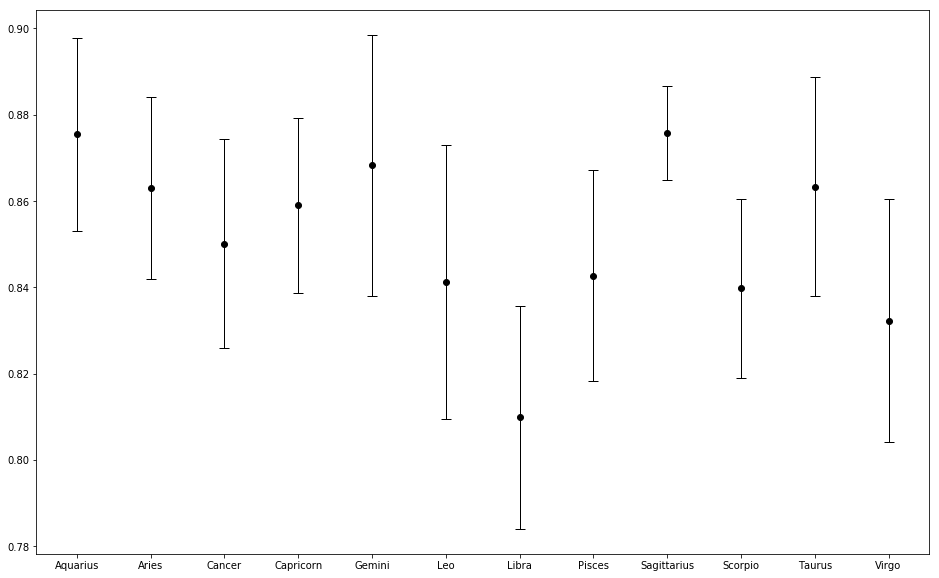

In [276]:
# TODO NOT WORKING

plt.figure(figsize = (16,10))
mean_dict = {}
std_dict = {}


for sign1, mean in mean_sign_out_degree.items():
    mean_values = []
    for sign in mean_sign_out_degree[sign1]:
        mean_values.append(mean_sign_out_degree[sign1][sign])
    print(mean_values)
    mean_dict[sign1] =  np.mean(mean_values)
    std_dict[sign1] = np.std(mean_values)
    
plt.errorbar(mean_dict.keys(), mean_dict.values(), yerr=std_dict.values(), fmt='ok', linewidth=1, capsize=5, ecolor='k', elinewidth=1)  
    

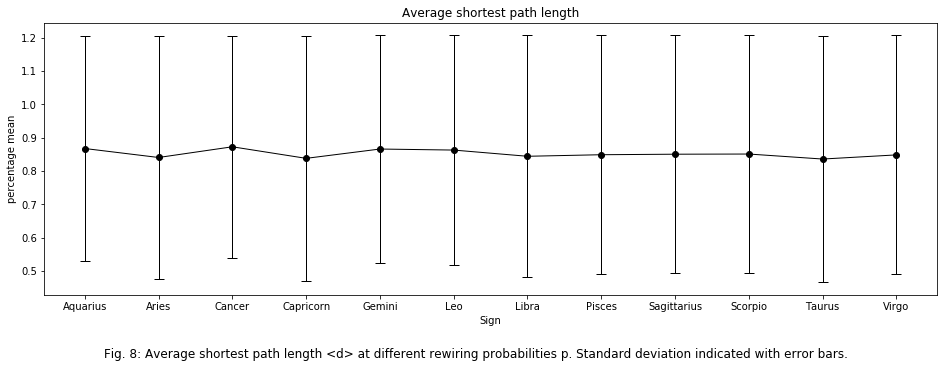

In [277]:
# TODO NOT WORKING

plt.figure(figsize = (16,5))
plt.errorbar(mean_out_degree.keys(), mean_out_degree.values(), yerr=std_out_degree.values(), fmt='-ok', linewidth=1, capsize=5, ecolor='k', elinewidth=1)  




plt.title("Average shortest path length")
plt.xlabel("Sign")
plt.ylabel("percentage mean")
plt.figtext(
    0.5, 
    -0.05, 
    'Fig. 8: Average shortest path length <d> at different rewiring probabilities p. Standard deviation indicated with error bars.', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)

plt.show()

In [278]:
# Display the network using forceAtlas

# Color the nodes based on the zodiac sign
node_color_zodiac = []
for node in G.nodes(data=True):
    # if the node has the attribute group1
    if node[1]['zodiac'] == 'Aries':
        node_color_zodiac.append('#FFFF66')
    elif node[1]['zodiac'] == 'Taurus':
        node_color_zodiac.append('gold')
    elif node[1]['zodiac'] == 'Gemini':
        node_color_zodiac.append('orange')
    elif node[1]['zodiac'] == 'Cancer':
        node_color_zodiac.append('orangered')
    elif node[1]['zodiac'] == 'Leo':
        node_color_zodiac.append('crimson')
    elif node[1]['zodiac'] == 'Virgo':
        node_color_zodiac.append('mediumvioletred')
    elif node[1]['zodiac'] == 'Libra':
        node_color_zodiac.append('darkviolet')
    elif node[1]['zodiac'] == 'Scorpio':
        node_color_zodiac.append('mediumblue')
    elif node[1]['zodiac'] == 'Sagittarius':
        node_color_zodiac.append('royalblue')
    elif node[1]['zodiac'] == 'Capricorn':
        node_color_zodiac.append('c')
    elif node[1]['zodiac'] == 'Aquarius':
        node_color_zodiac.append('green')
    elif node[1]['zodiac'] == 'Pisces':
        node_color_zodiac.append('limegreen')
    else:
        node_color_zodiac.append('grey')

# Color the nodes based on the element 
# TODO: Choose color for each element

node_color_element = []
for node in G.nodes(data=True):
    # if the node has the attribute group1
    if node[1]['element'] == 'Air':
        node_color_element.append('yellow')
    elif node[1]['element'] == 'Fire':
        node_color_element.append('orange')
    elif node[1]['element'] == 'Water':
        node_color_element.append('blue')
    elif node[1]['element'] == 'Earth':
        node_color_element.append('green')
    else:
        print(node[1]['element'])
        node_color_element.append('grey')
        
# Size the nodes based on their degree
node_size = [v*0.5 for v in dict(G.degree).values()]

# Configure forceAtlas
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=False)

# Obtain the positions
positions = forceatlas2.forceatlas2_networkx_layout(U, pos=None, iterations=200)

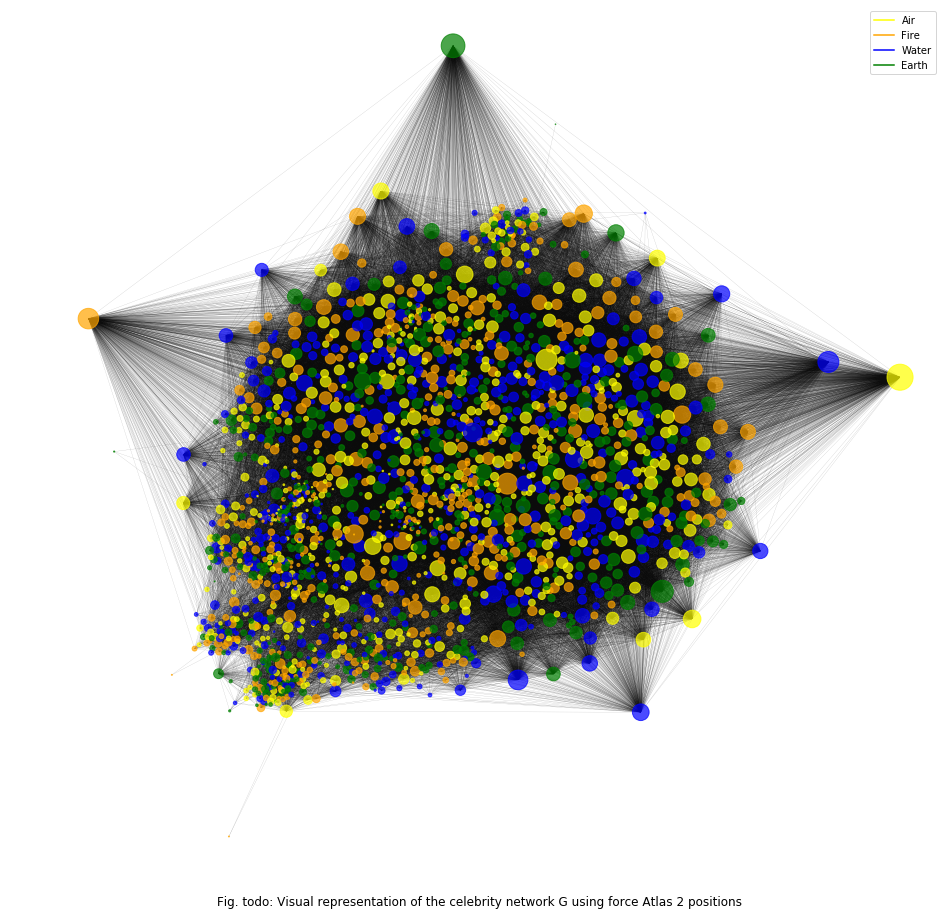

In [207]:
plt.figure(figsize = (16,16))


# PLot the undirected graph
nx.draw_networkx_nodes(U, pos=positions, alpha=0.7, node_size=node_size, node_color=node_color_element)
nx.draw_networkx_edges(U, pos=positions, alpha=0.3,width=0.2)


# Caption figure
plt.figtext(
    0.5, 
    0.1, 
    'Fig. todo: Visual representation of the celebrity network G using force Atlas 2 positions', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)

# Create legend

for label in color_legend_element:
    plt.plot([0],[0],color=color_legend_element[label],label=label)
plt.legend()
plt.axis('off')
plt.show()

In [68]:
# load AFINN words
afinn_words = dict(map(lambda kv: (kv[0],int(kv[1])), 
                     [ line.split('\t') for line in open("./AFINN/AFINN-111.txt") ]))

In [165]:
# Tokenize the tweets to add them as node attributes

# Remove stopwords from the two most common languages
stopwords = sw.words('english') + sw.words('spanish') + sw.words('portuguese') + sw.words('french')
englishwords = words.words() + list(afinn_words.keys())
tokenizer = WhitespaceTokenizer()

tokens_dict = {}

#remove punctuation (but keep hashtags)
#if word is not a hashtag
    #only keep if it is in english


# TODO: Remove words like "bri..."
for node in df.Handle:
    tweets = df.loc[df['Handle'] == node].Tweets.values
    tweet_words = ' '.join(tweets)
      
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    raw = pattern.sub('', tweet_words)
    raw = raw.replace('\\n',' ')
    raw = raw.replace('\\',' ')
    raw = raw.replace('=',' ')
    raw = raw.replace('/',' ')
    raw = raw.replace('(',' ')
    raw = raw.replace(')',' ')
    raw = raw.replace(',',' ')
    raw = raw.replace('.',' ')
    raw = raw.lower()
       
    
    tweet_words = tokenizer.tokenize(raw)
    

    tweet_words = [word for word in tweet_words if (word not in stopwords and word in englishwords)]
    
    tokens_dict[node] = tweet_words

    
nx.set_node_attributes(G, tokens_dict, "tokens")    

In [166]:
#TODO: move this to the snippet above

for node in df.Handle:
    tokens_dict[node] = [word for word in tokens_dict[node] if word[0] != '#']

In [167]:
nx.set_node_attributes(G, tokens_dict, "tokens")  

In [168]:
# Get the term frequency for our communities (zodiac signs)

words = set()
# Create documents with the words of each character in each community
documents = {}
# Compile term frequencies for each community
tf = {}

tokens = nx.get_node_attributes(G, 'tokens')
zodiacs = nx.get_node_attributes(G, 'zodiac').items()

for zodiac in ZODIAC_SIGNS:
    nodes = [x for x, y in zodiacs if y==zodiac]
    
    document = []
    for user in nodes:
        document = document + tokens[user]
    words.update(document)
    documents[zodiac] = document
    
    # Get the term frequency for the document
    tf[zodiac] = FreqDist(document) 


In [169]:
# Get the inverse document frequency for our communities (zodiac signs)
idf = {}
for word in words:
    nt = 0
    for _, doc in documents.items():
        if word in doc:
            nt +=1
    idf[word]= np.log(10/nt)

In [170]:
# Get the TF-IDF for our communities (zodiac signs)
tf_idf = {}
for zodiac in ZODIAC_SIGNS:
    tf_idf[zodiac] = {}

    for word, termf in tf[zodiac].items() :
        tf_idf[zodiac][word] = termf * idf[word]


In [172]:
# TODO REMOVE IF NOT NEEDED 
# SAVE USEFUL DATA
import pickle

with open('./datafiles/tf_idf.pickle', 'wb') as handle:
    pickle.dump(tf_idf, handle)
with open('./datafiles/idf.pickle', 'wb') as handle:
    pickle.dump(idf, handle)
with open('./datafiles/g.pickle', 'wb') as handle:
    pickle.dump(G, handle)
with open('./datafiles/tokens_dict.pickle', 'wb') as handle:
    pickle.dump(tokens_dict, handle)

In [75]:
# TODO REMOVE IF NOT NEEDED 
# LOAD USEFUL DATA
import pickle

with open('./datafiles/tf_idf.pickle', 'rb') as handle:
    tf_idf = pickle.load(handle)
with open('./datafiles/idf.pickle', 'rb') as handle:
    idf = pickle.load(handle)
with open('./datafiles/g.pickle', 'rb') as handle:
    G = pickle.load(handle)
with open('./datafiles/tokens_dict.pickle', 'rb') as handle:
    tokens_dict = pickle.load(handle)


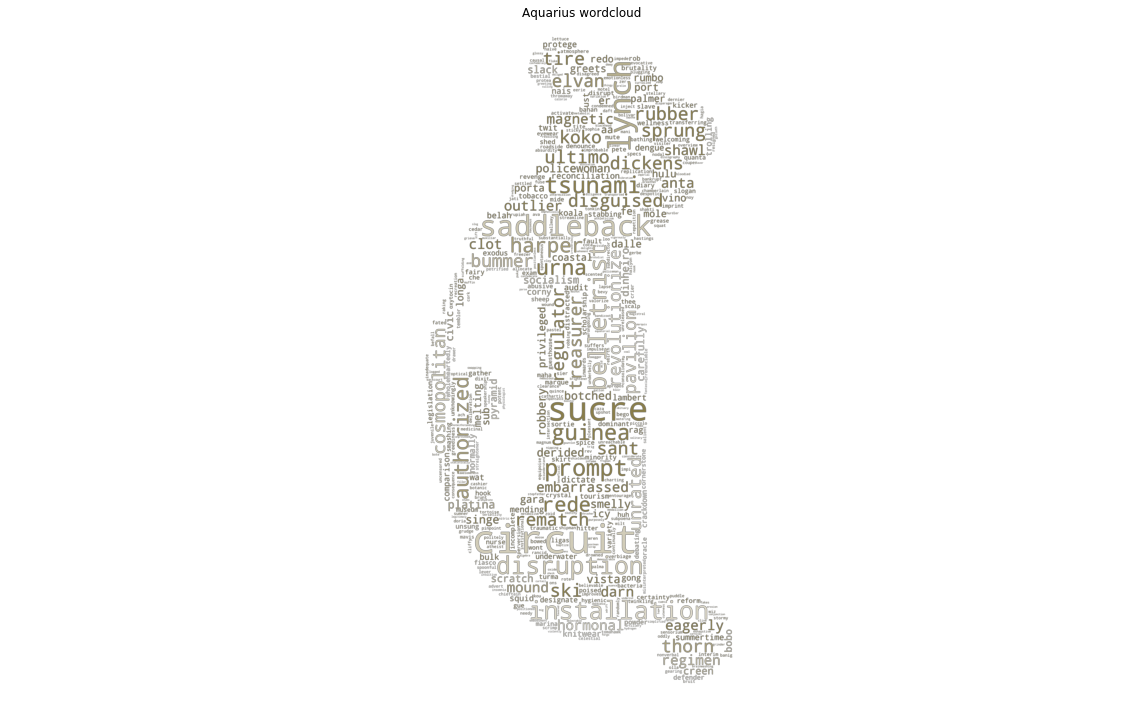

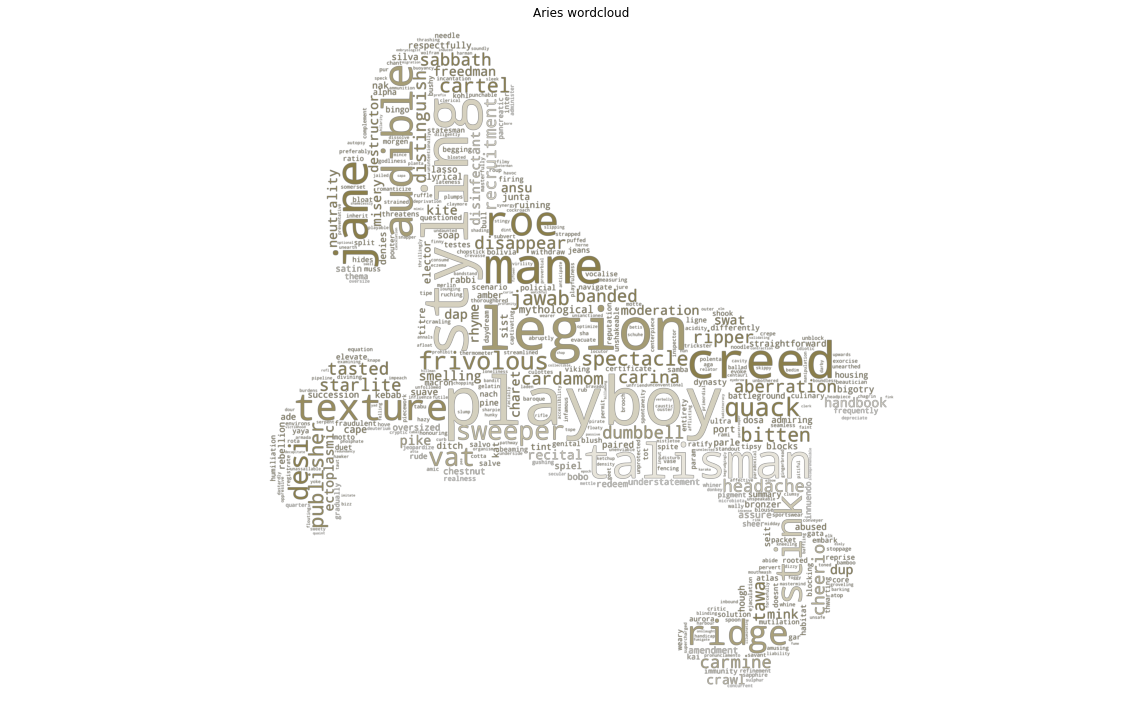

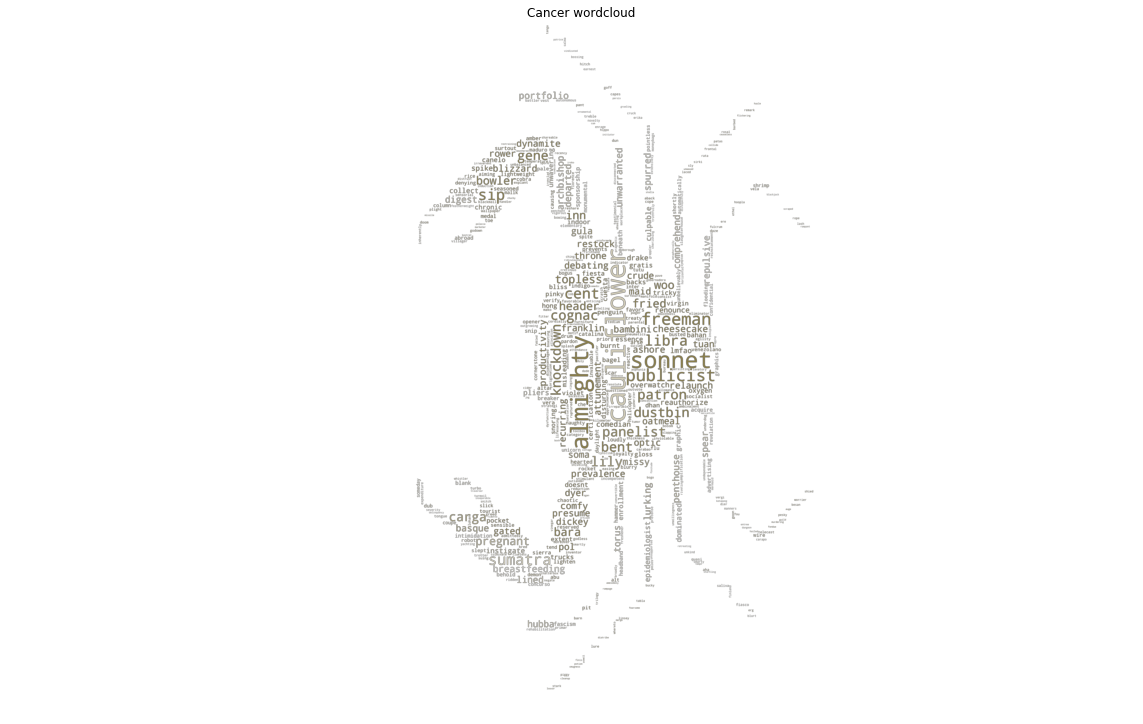

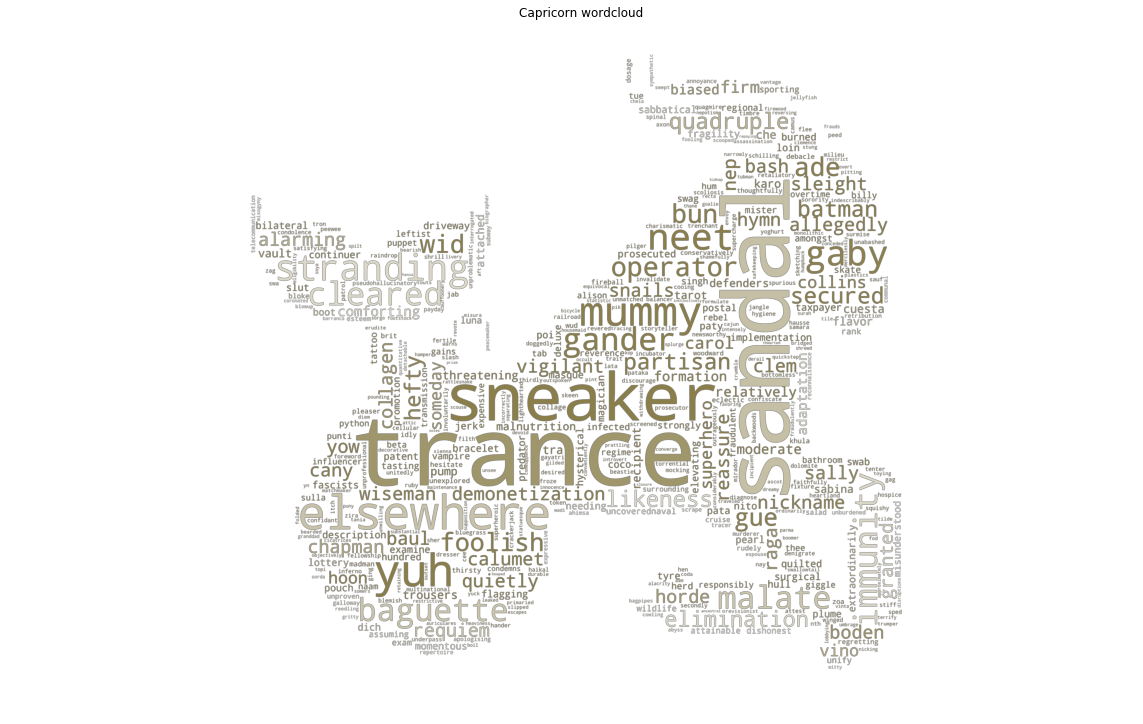

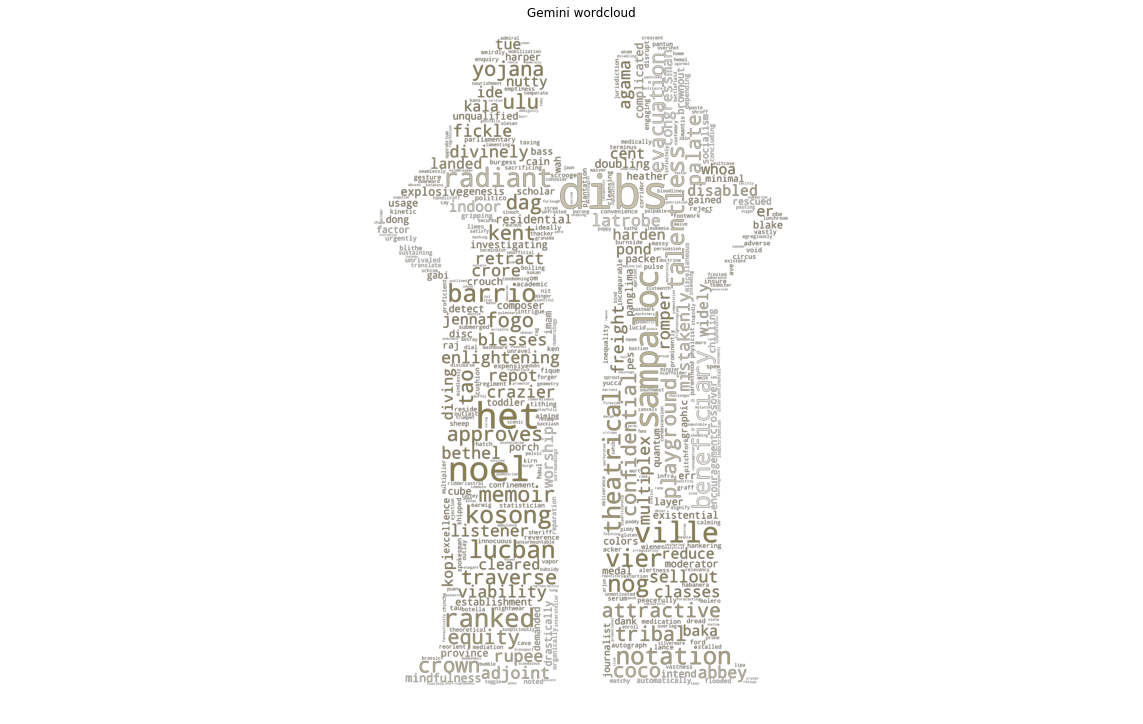

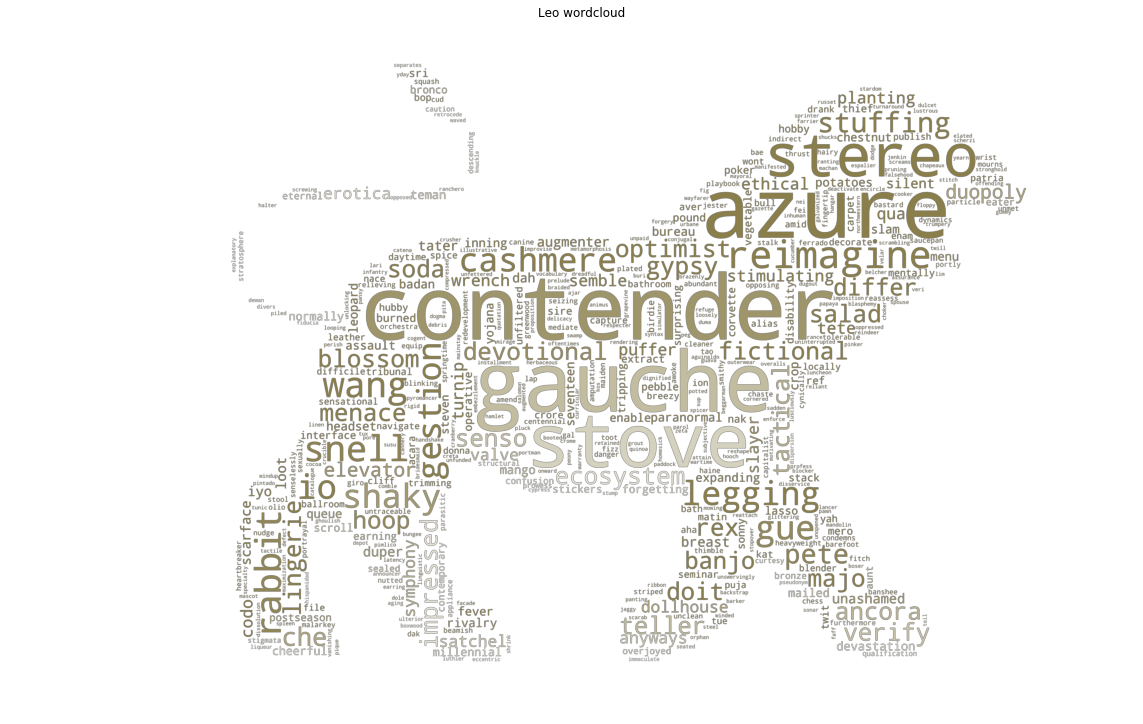

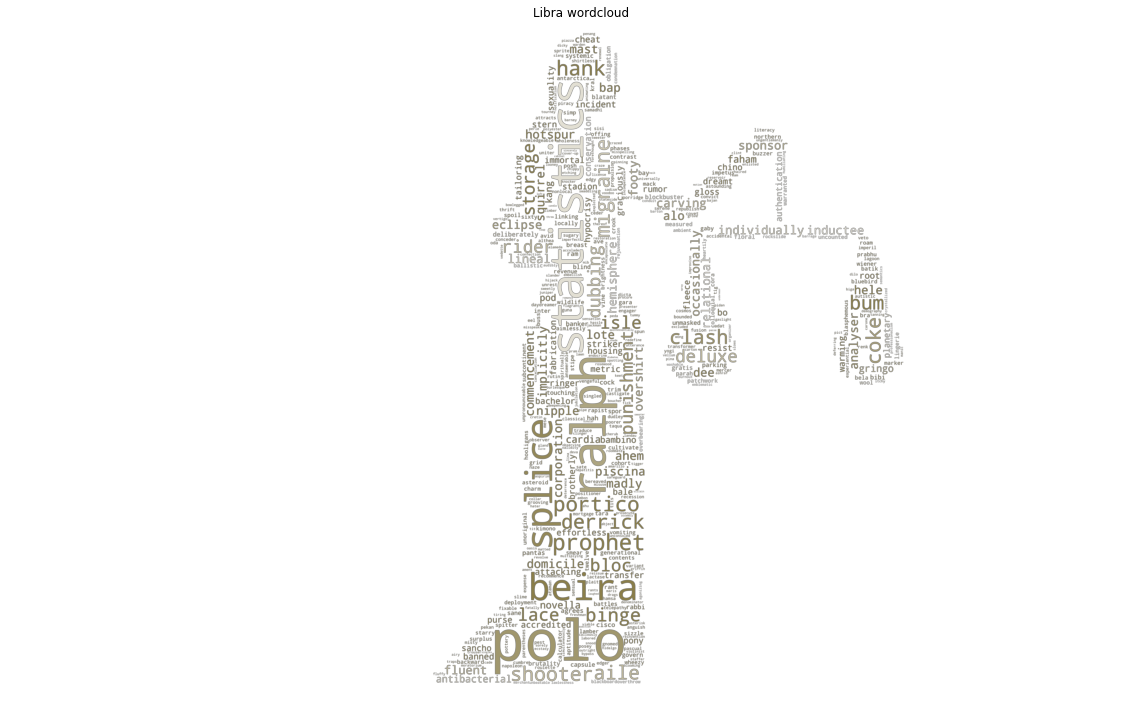

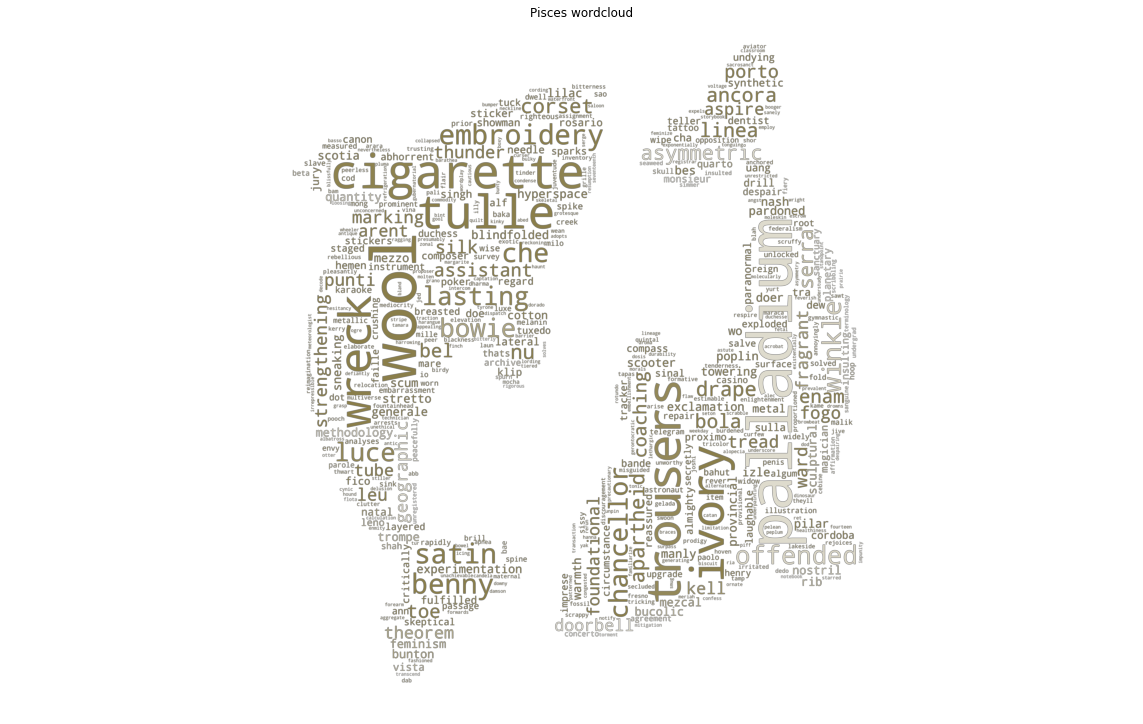

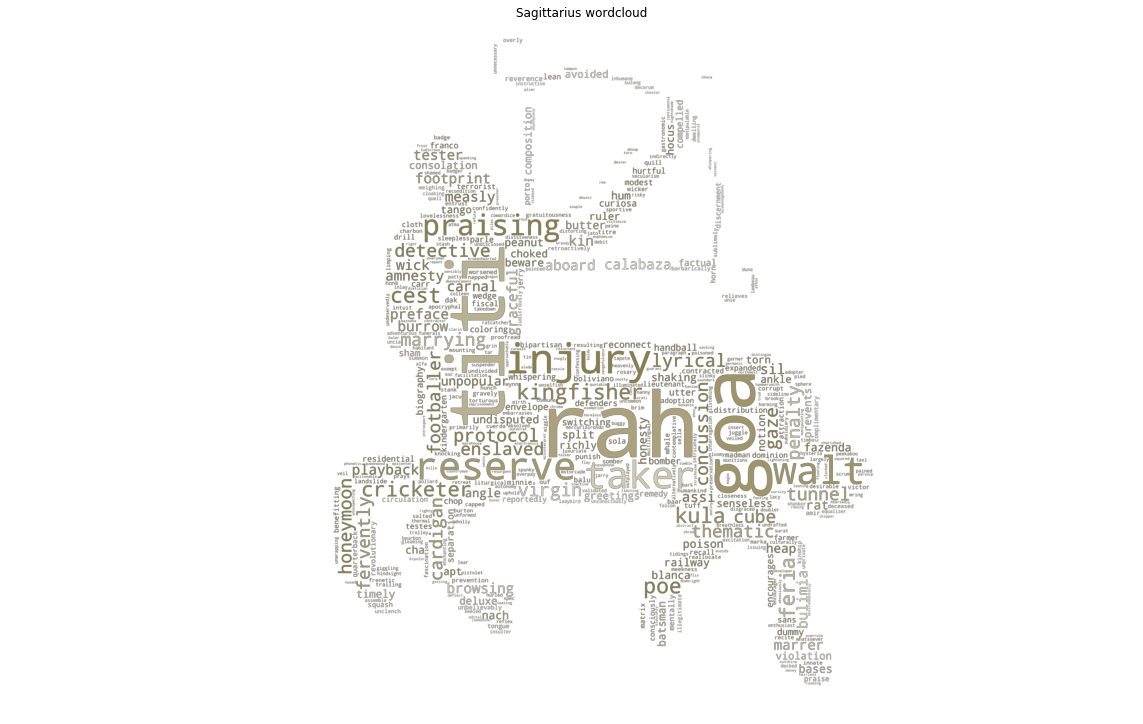

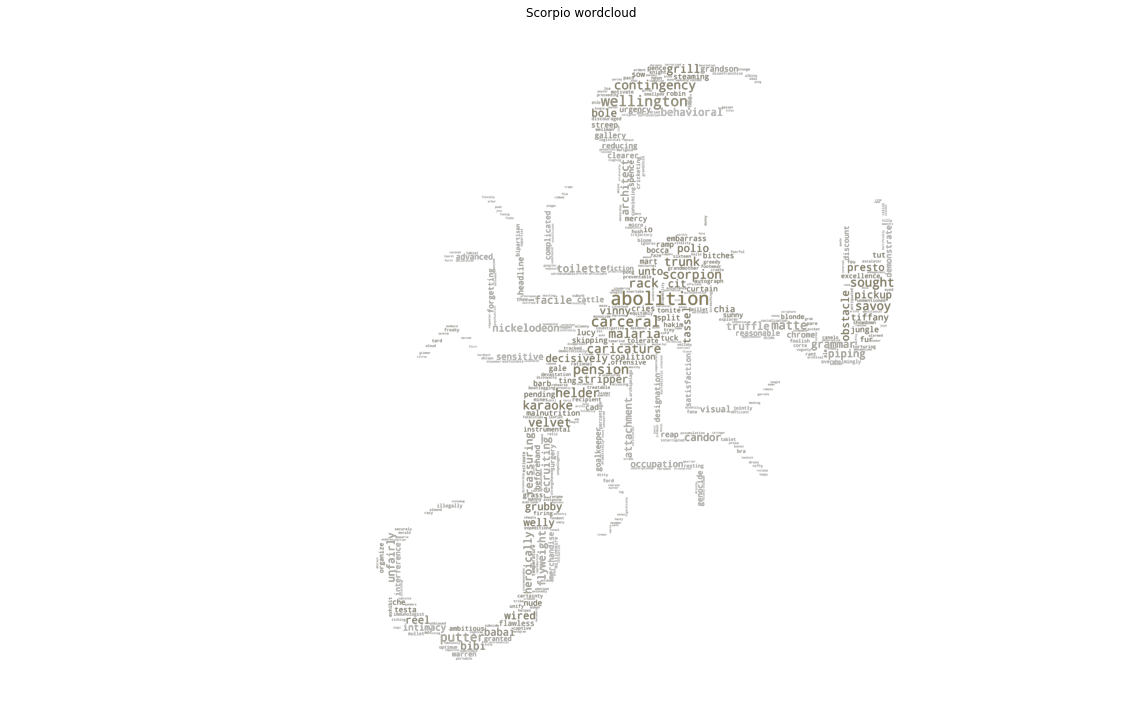

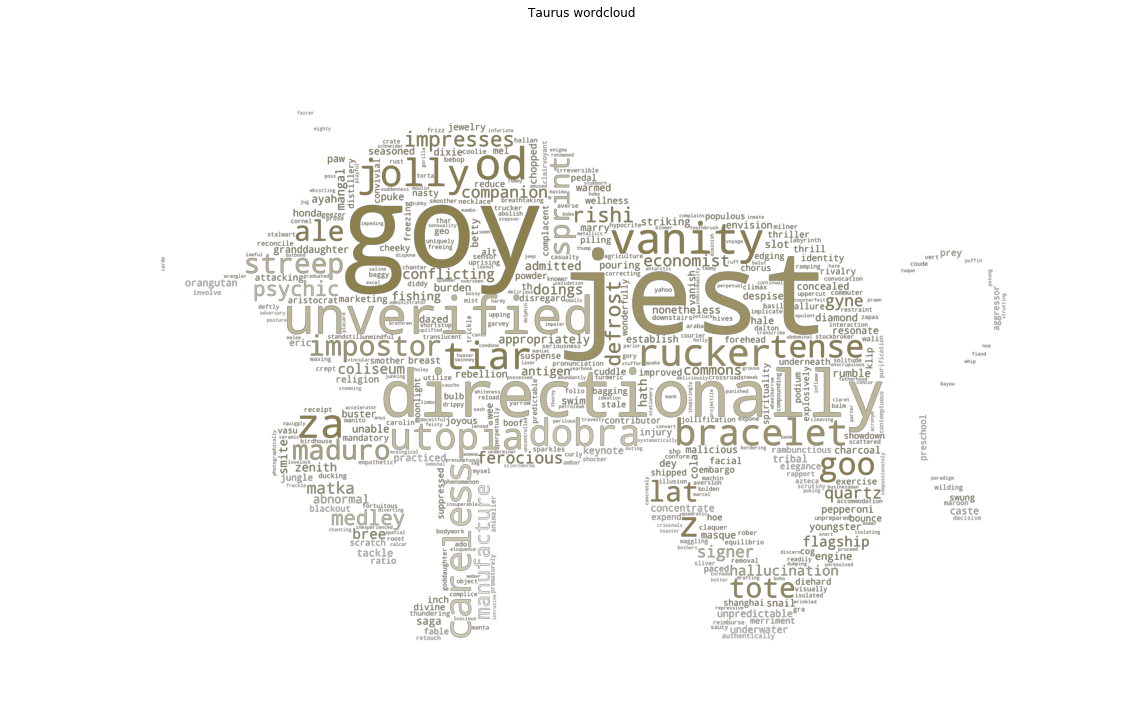

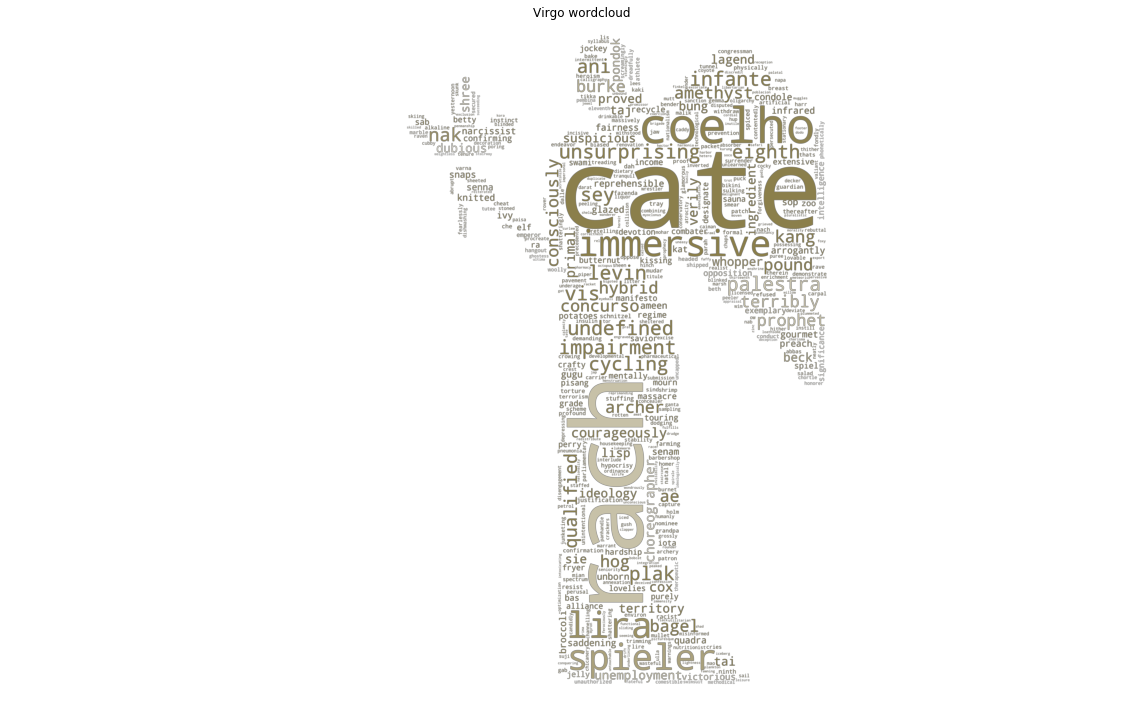

In [5]:
# Create a wordcloud for each sign
for zodiac in ZODIAC_SIGNS:
    fdist = tf_idf[zodiac]
    mask_zodiac = np.array(Image.open("./images/" + zodiac + ".png"))

    # Create the wordclouds with a transparent background and the shape of the zodiac sign
    wc_zodiacs = WordCloud(width=8000, height=5000, mode="RGBA", background_color = None, max_words=500, mask=mask_zodiac, collocations = False).generate_from_frequencies(fdist)

    # Color the wordcloud with the colors of the zodiac sign
    image_colors = ImageColorGenerator(mask_zodiac)

    # Plot the wordcloud
    plt.figure(figsize = (16,10))
    plt.imshow(wc_zodiacs.recolor(color_func=image_colors), interpolation='bilinear')
    plt.axis("off")
    
    # Save the wordcloud
    plt.tight_layout()
    plt.savefig("./images/" + zodiac + "_wordcloud.png", transparent=True)
    
    # Add caption to figure
    plt.title(zodiac + " wordcloud")
    plt.show()

    

In [279]:
# Create a wordcloud for each element ????

for element in ZODIAC_ELEMENTS:
    
    fdist = nltk.FreqDist(words)
    
    mask_element = np.array(Image.open("./images/" + element + ".png"))

    # Create the wordclouds with a transparent background and the shape of the zodiac sign
    wc_element = WordCloud(width=800, height=800, mode="RGBA", background_color = None, max_words=2000, mask=mask_element, collocations = False).generate_from_frequencies(fdist)

    # Color the wordcloud with the colors of the zodiac sign
    image_colors = ImageColorGenerator(mask_element)

    # Plot the wordcloud
    plt.figure(figsize = (17,17))
    plt.imshow(wc_element.recolor(color_func=image_colors), interpolation='bilinear')
    plt.axis("off")
    
    # Save the wordcloud
    plt.savefig("./images/" + element + "_wordcloud.png", transparent=True)
    
    # Add caption to figure
  
    plt.show()


TypeError: 'LazyCorpusLoader' object is not iterable

In [280]:
# Communities

# Create communities, stored in partition dictionary
partition = community_louvain.best_partition(U)

# Count number of different community values
counts = Counter(partition.values())

print("There is a total of " + str(len(counts)) + " communities in our network")

There is a total of 10 communities in our network


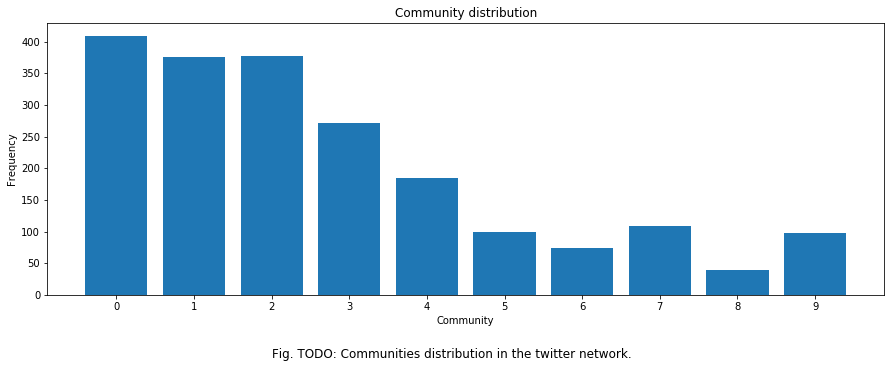

In [299]:
# Plot community distribution

# Store community values as list for histogram
communities = [value for key, value in partition.items()]
counts = Counter(communities)

# Create histrogram with a bin for each value in the community range (communities are integers)
plt.figure(figsize = (15,5))
plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()))

# Format plot
plt.title("Community distribution")
plt.ylabel("Frequency")
plt.xlabel("Community")
plt.figtext(
    0.5, 
    -0.05, 
    'Fig. TODO: Communities distribution in the twitter network.', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)
plt.show()

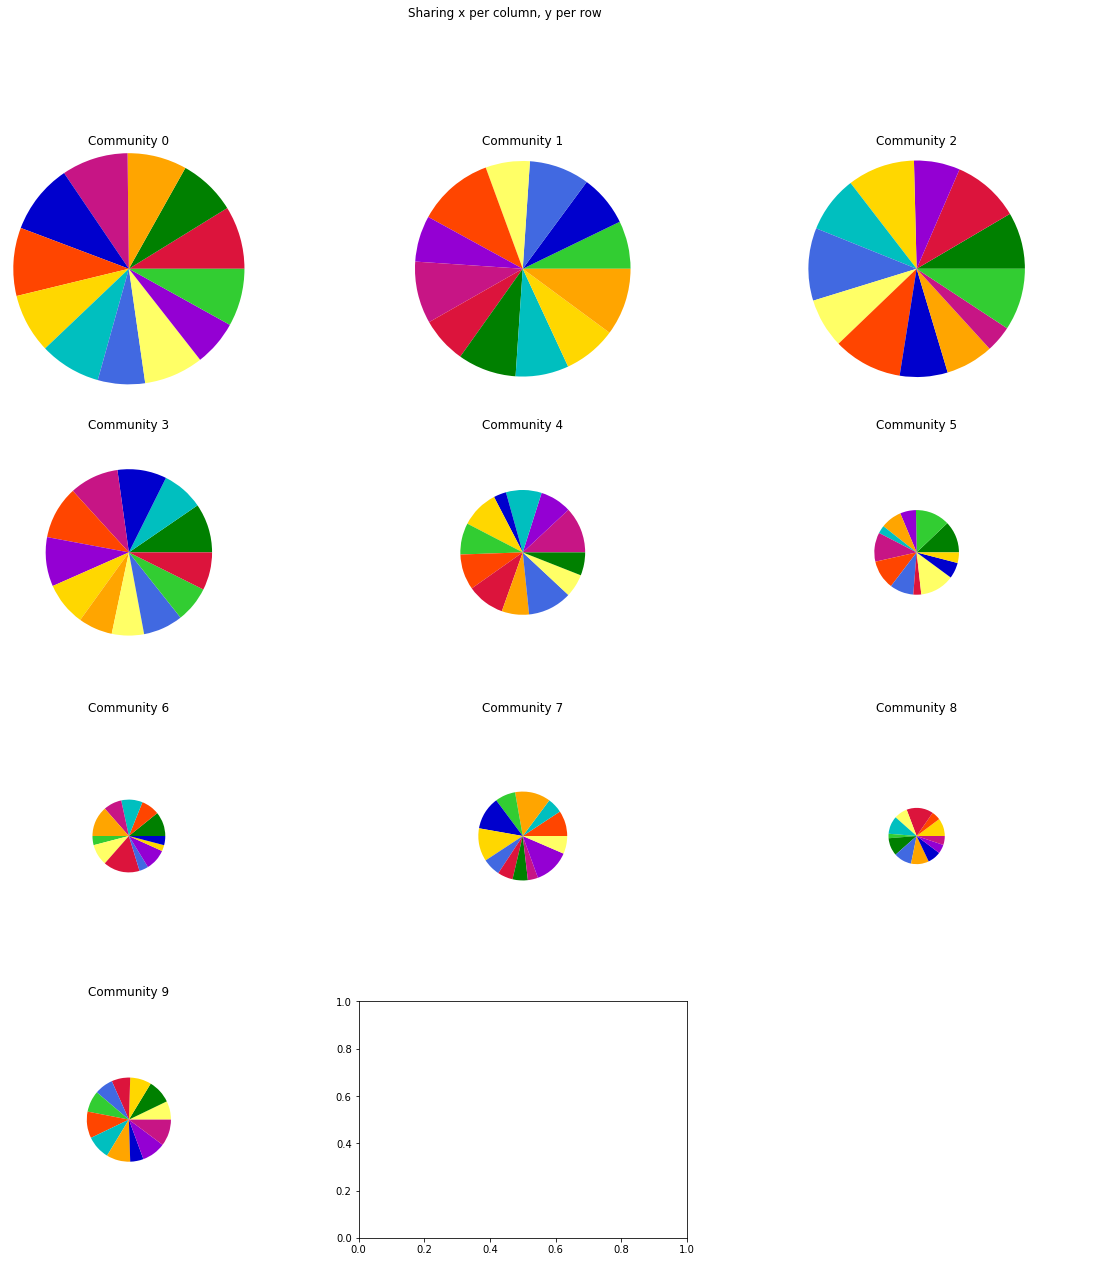

In [303]:
# Plot zodiac distribution inside each community
# TODO Remove axis at the end

communities = partition.items()
counts = Counter([value for key, value in communities])
zodiacs = nx.get_node_attributes(G, 'zodiac')

fig, subplots = plt.subplots(int(np.ceil(len(counts)/3)), 3, figsize=(20,20))

fig.suptitle('Sharing x per column, y per row')
#print(subplots)
subplots = subplots.flatten()
for comm in range(len(counts)):
    data = []
    same_comm = [k for k,v in communities if v == comm]
    for user in same_comm:
        data.append(zodiacs[user])
    data_counts = Counter(data)
    #subplots[comm].title("Community "+ str(comm))
    #subplots[comm].figure(figsize = (16,16))
    subplots[comm].title.set_text("Community "+ str(comm))
    subplots[comm].pie(list(data_counts.values()), colors=[color_legend_zodiac[zodiac] for zodiac in data_counts.keys()], radius = 0.2+counts[comm]/400)         
    plt.axis("off")

plt.show()

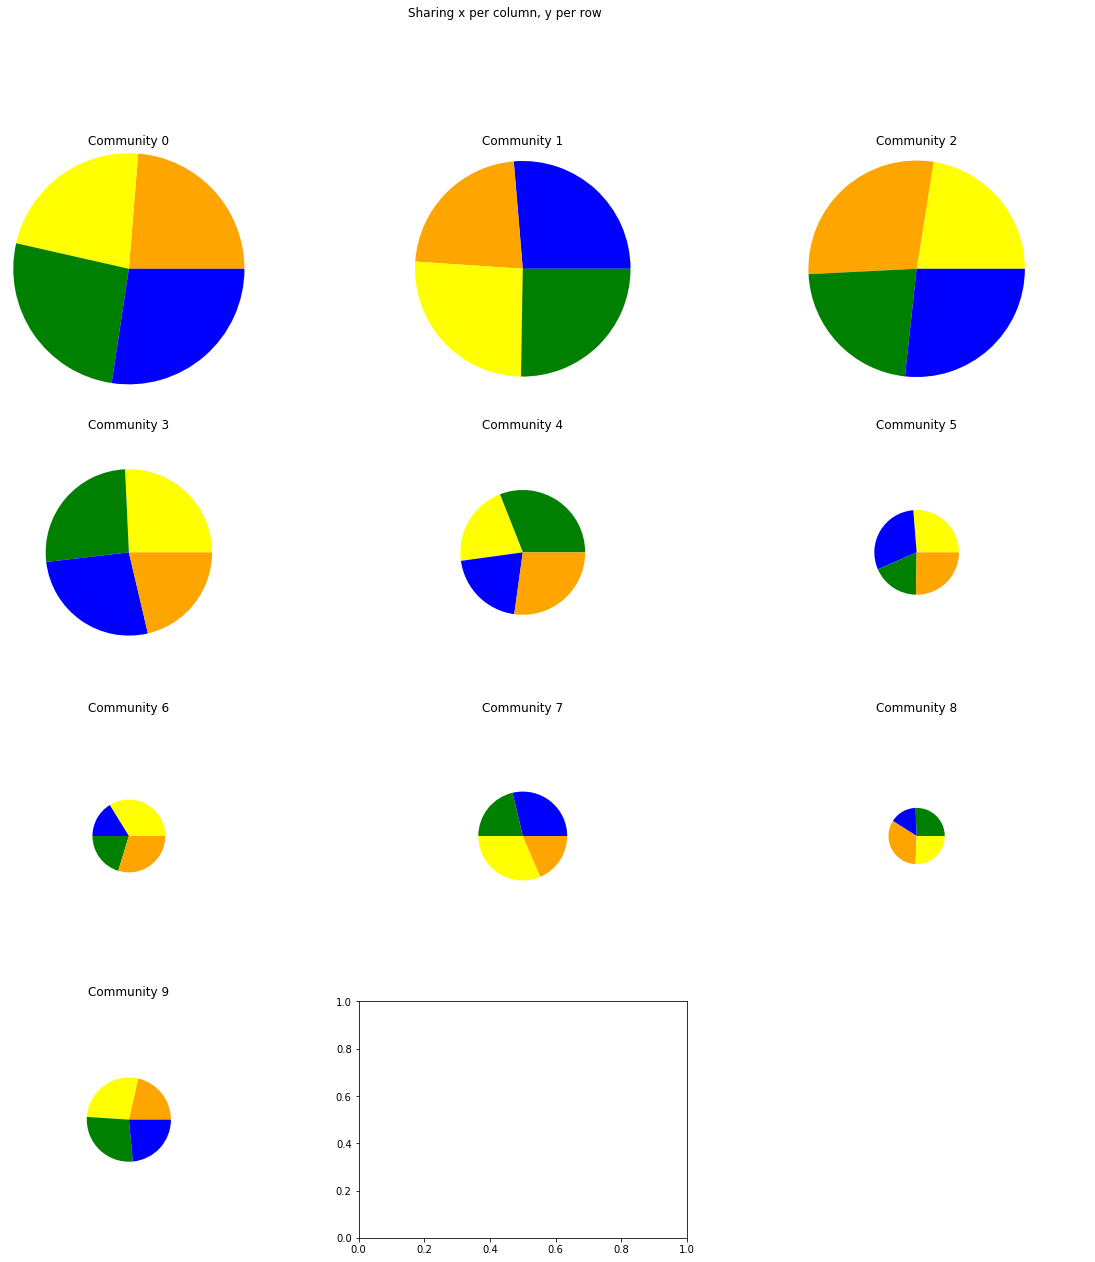

In [304]:
# Plot zodiac distribution inside each community
# TODO Remove axis at the end

communities = partition.items()
counts = Counter([value for key, value in communities])
elements = nx.get_node_attributes(G, 'element')


fig, subplots = plt.subplots(int(np.ceil(len(counts)/3)), 3, figsize=(20,20))

fig.suptitle('Sharing x per column, y per row')
#print(subplots)
subplots = subplots.flatten()
for comm in range(len(counts)):
    data = []
    same_comm = [k for k,v in communities if v == comm]
    for user in same_comm:
        data.append(elements[user])
    data_counts = Counter(data)
    #subplots[comm].title("Community "+ str(comm))
    #subplots[comm].figure(figsize = (16,16))
    subplots[comm].title.set_text("Community "+ str(comm))
    subplots[comm].pie(list(data_counts.values()), colors=[color_legend_element[element] for element in data_counts.keys()], radius = 0.2+counts[comm]/400)         
    plt.axis("off")
plt.show()

In [305]:
# Show the 3 more popular accounts in each community
communities = partition.items()
counts = Counter([value for key, value in communities])

for comm in range(len(counts)):
    user_popularity = {}
    same_comm = [k for k,v in communities if v == comm]
    for user in same_comm:
        user_popularity[user] =  G.in_degree(user)
        #char_sentiment.append(sentiment_dict[char]
    sorted_user_popularity_community = sorted(user_popularity.items(), key=lambda x: x[1], reverse=True)
    print("Community ", comm, ": ", *sorted_user_popularity_community[:3])

Community  0 :  ('@barackobama', 752) ('@theellenshow', 637) ('@jimmyfallon', 551)
Community  1 :  ('@rihanna', 500) ('@ladygaga', 448) ('@justinbieber', 444)
Community  2 :  ('@jlo', 313) ('@evalongoria', 207) ('@shakira', 185)
Community  3 :  ('@jtimberlake', 414) ('@kanyewest', 357) ('@drake', 347)
Community  4 :  ('@leodicaprio', 340) ('@priyankachopra', 125) ('@narendramodi', 124)
Community  5 :  ('@paulocoelho', 228) ('@neymarjr', 143) ('@kaka', 122)
Community  6 :  ('@oprah', 463) ('@agnezmo', 56) ('@lunamaya26', 34)
Community  7 :  ('@rterdogan', 43) ('@hhshkmohd', 41) ('@cuneytozdemir', 23)
Community  8 :  ('@therock', 262) ('@thenotoriousmma', 107) ('@rondarousey', 106)
Community  9 :  ('@mannypacquiao', 80) ('@jason_mraz', 77) ('@annecurtissmith', 67)


In [306]:
# Show the 3 more popular accounts in each zodiac
zodiacs = nx.get_node_attributes(G, 'zodiac').items()

for sign in ZODIAC_SIGNS:
    user_popularity = {}
    same_sign = [k for k,v in zodiacs if v == sign]
    for user in same_sign:
        user_popularity[user] =  G.in_degree(user)
        #char_sentiment.append(sentiment_dict[char]
    sorted_user_popularity_zodiac = sorted(user_popularity.items(), key=lambda x: x[1], reverse=True)
    print(sign, ": ", *sorted_user_popularity_zodiac[:3])

Aquarius :  ('@theellenshow', 637) ('@oprah', 463) ('@jtimberlake', 414)
Aries :  ('@ladygaga', 448) ('@pharrell', 289) ('@emmawatson', 269)
Cancer :  ('@elonmusk', 356) ('@tomhanks', 339) ('@arianagrande', 329)
Capricorn :  ('@ryanseacrest', 344) ('@kingjames', 330) ('@jimcarrey', 298)
Gemini :  ('@kanyewest', 357) ('@realdonaldtrump', 328) ('@andersoncooper', 258)
Leo :  ('@barackobama', 752) ('@jlo', 313) ('@ddlovato', 279)
Libra :  ('@kimkardashian', 313) ('@snoopdogg', 308) ('@kamalaharris', 307)
Pisces :  ('@rihanna', 500) ('@justinbieber', 444) ('@iamwill', 228)
Sagittarius :  ('@taylorswift13', 386) ('@chrissyteigen', 307) ('@sarahksilverman', 299)
Scorpio :  ('@katyperry', 412) ('@jimmykimmel', 349) ('@drake', 347)
Taurus :  ('@adele', 274) ('@therock', 262) ('@stephenathome', 244)
Virgo :  ('@jimmyfallon', 551) ('@pink', 262) ('@paulocoelho', 228)


In [287]:
def sentiment(tokens):
    try:
        return np.mean([afinn_words[token] for token in tokens if token in afinn_words.keys()])
    except:
        return 0

In [288]:
tokens = nx.get_node_attributes(G, 'tokens').items()

user_sentiment = {}
for user, token_list in tokens:
    user_sentiment[user] = sentiment(token_list)

C:\Users\lulka\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lulka\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [289]:
# Sentiment analysis for zodiac signs
zodiacs = nx.get_node_attributes(G, 'zodiac').items()

zodiac_sentiments = {}
mean_sentiments = {}
std_sentiments = {}

for sign in ZODIAC_SIGNS:
    zodiac_sentiments[sign] = []
    same_sign = [k for k,v in zodiacs if v == sign]
    for user in same_sign:
        zodiac_sentiments[sign].append(user_sentiment[user])
    mean_sentiments[sign] = np.nanmean(zodiac_sentiments[sign])
    std_sentiments[sign] = np.nanstd(zodiac_sentiments[sign])


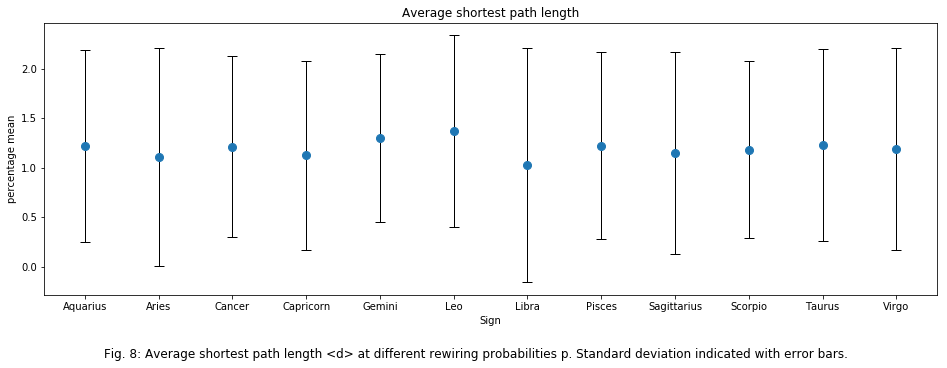

In [307]:
# Average sentiment for each zodiac

# TODO add colors
plt.figure(figsize = (16,5))
plt.errorbar(mean_sentiments.keys(), mean_sentiments.values(), yerr=std_sentiments.values(), 
             fmt='o', linewidth=1, capsize=5, ecolor='k', elinewidth=1, markersize = 8)
#print(markerfacecolor = [color_legend_zodiac[s] for s in list(mean_sentiments.keys())])
plt.title("Average shortest path length")
plt.xlabel("Sign")
plt.ylabel("percentage mean")
plt.figtext(
    0.5, 
    -0.05, 
    'Fig. 8: Average shortest path length <d> at different rewiring probabilities p. Standard deviation indicated with error bars.', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)

plt.show()

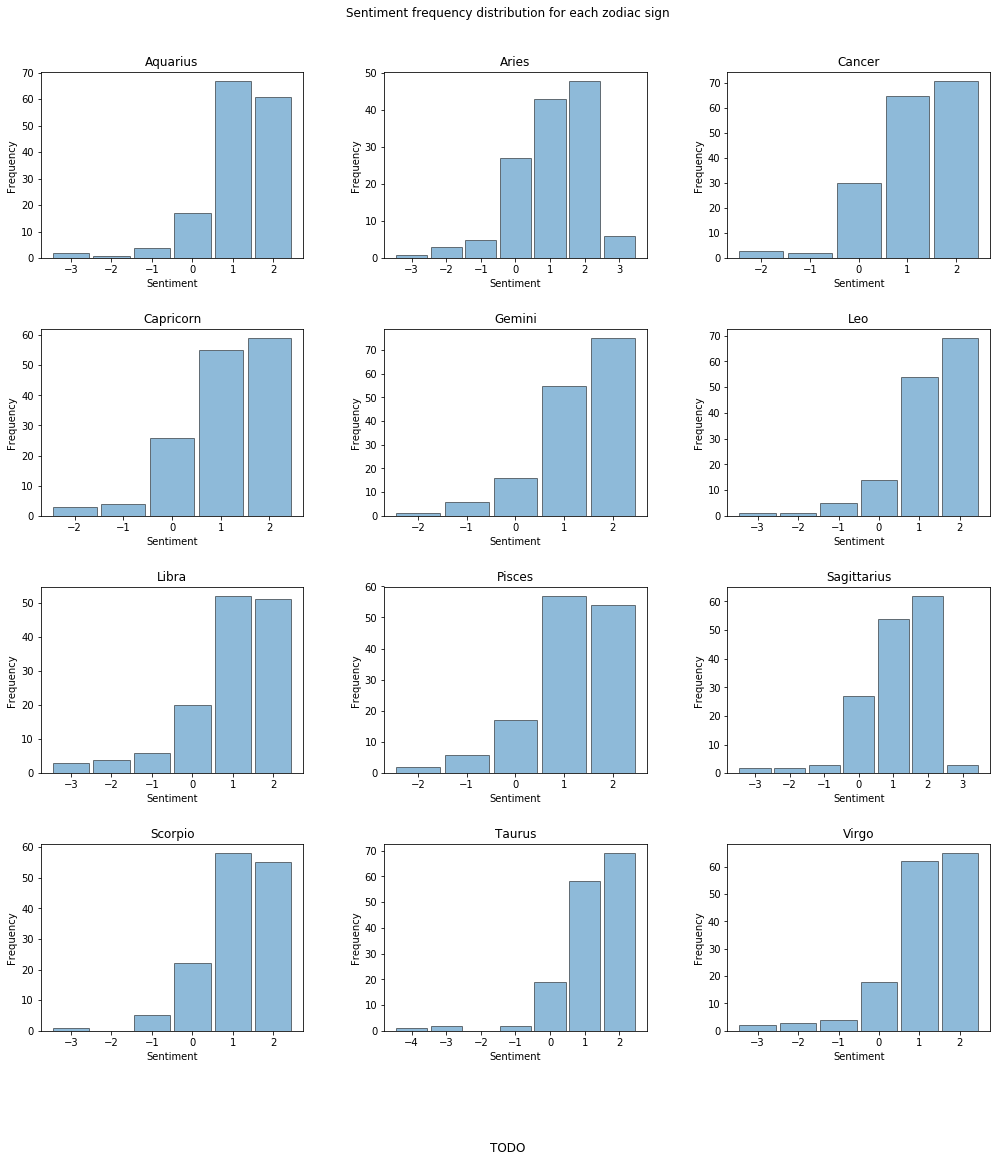

In [308]:
# Sentiment frequency distribution for each sign

fig, subplots = plt.subplots(int(np.ceil(len(ZODIAC_SIGNS)/3)), 3, figsize=(15,15))
subplots = subplots.flatten()
fig.suptitle('Sentiment frequency distribution for each zodiac sign', y=1.01)
fig.tight_layout(pad=5.0)
for sign_index in range(len(ZODIAC_SIGNS)):

    bins = np.arange(int(np.nanmin(zodiac_sentiments[ZODIAC_SIGNS[sign_index]])), int(np.nanmax(zodiac_sentiments[ZODIAC_SIGNS[sign_index]])+1))-0.5
    subplots[sign_index].title.set_text(ZODIAC_SIGNS[sign_index])
    subplots[sign_index].hist(zodiac_sentiments[ZODIAC_SIGNS[sign_index]], bins=bins, alpha=0.5, label="in", histtype='bar', ec='black', rwidth=0.9)         
    subplots[sign_index].set_ylabel('Frequency')
    subplots[sign_index].set_xlabel('Sentiment')

plt.figtext(
        0.5, 
        -0.05, 
        'TODO', 
        wrap=True, 
        horizontalalignment='center', 
        fontsize=12
)   
plt.show()

In [ ]:
#t-value: https://stackoverflow.com/questions/19339305/python-function-to-get-the-t-statistic
# Confidence interval: https://online.stat.psu.edu/stat415/lesson/2/2.6
p = 0.02

# yerr: shape(2,N): Separate - and + values for each bar.
# First row contains the lower errors, the second row contaRins the upper errors.



In [309]:
# Sentiment analysis for communities

communities = partition.items()
counts = Counter([value for key, value in communities])

community_sentiments = {}
mean_sentiments = {}
std_sentiments = {}

for comm in range(len(counts)):
    community_sentiments[comm] = []
    same_comm = [k for k,v in communities if v == comm]
    for user in same_comm:   
        community_sentiments[comm].append(user_sentiment[user])
    mean_sentiments[comm] = np.nanmean(community_sentiments[comm])
    std_sentiments[comm] = np.nanstd(community_sentiments[comm])
    
    

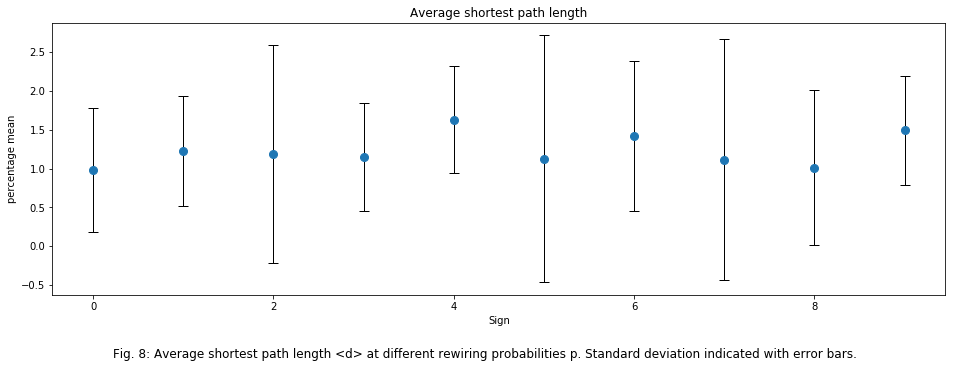

In [310]:
# Average sentiment for each community

# TODO add colors
plt.figure(figsize = (16,5))
plt.errorbar(mean_sentiments.keys(), mean_sentiments.values(), yerr=std_sentiments.values(), 
             fmt='o', linewidth=1, capsize=5, ecolor='k', elinewidth=1, markersize = 8)
#print(markerfacecolor = [color_legend_zodiac[s] for s in list(mean_sentiments.keys())])
plt.title("Average shortest path length")
plt.xlabel("Sign")
plt.ylabel("percentage mean")
plt.figtext(
    0.5, 
    -0.05, 
    'Fig. 8: Average shortest path length <d> at different rewiring probabilities p. Standard deviation indicated with error bars.', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)

plt.show()


This is for joining all the data whenever its ready

In [31]:
with open("./datafiles/full_friends.pickle", "rb") as r:
    friends = pickle.load(r)
print(len(friends))
#df['Tokens'] = df['Handle'].map(tokens_dict) 
df['Following'] = df['Handle'].map(friends)


2152


In [34]:
with open("./datafiles/ids.pickle", "rb") as r:
    ids = pickle.load(r)
    
df['Id'] = df['Handle'].map(ids)